In [12]:
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import numpy as np
import os
import nrrd
import pytorch_lightning as pl
from monai.data import Dataset, DataLoader
from monai.transforms import Compose, Lambda, RandSpatialCrop, RandRotate90, ToTensor
from monai.networks.nets import UNet
#from monai.losses import DiceLoss
import tensorflow as tf
from torch.utils.tensorboard import SummaryWriter

In [50]:
import shutil

def clear_tensorboard_logs(log_dir):
    # Ensure the directory exists
    if os.path.exists(log_dir):
        # Delete the directory and its contents
        shutil.rmtree(log_dir)
        print("TensorBoard logs cleared successfully.")
    else:
        print("TensorBoard logs directory not found.")

def clear_logs(logs_dir):
    """Clear all logs in the specified directory."""
    try:
        shutil.rmtree(logs_dir)
        print(f"All logs in {logs_dir} have been cleared.")
    except FileNotFoundError:
        print(f"No logs found in {logs_dir}.")
def clear_runs_and_logs(logs_dir):
    """Clear all runs and logs in the specified directory."""
    try:
        shutil.rmtree(logs_dir)
        print(f"All runs and logs in {logs_dir} have been cleared.")
    except FileNotFoundError:
        print(f"No runs or logs found in {logs_dir}.")

# Specify the directory containing all runs and logs
runs_and_logs_dir = "./runs_and_logs/"
log_dir = "./logs/"
tensorboard_logs_dir = "./tensorboard_logs/"
lightning_logs_dir = "./lightning_logs/"
# Clear TensorBoard logs
clear_tensorboard_logs(log_dir)
clear_logs(lightning_logs_dir)
clear_runs_and_logs(runs_and_logs_dir)

TensorBoard logs cleared successfully.
All logs in ./lightning_logs/ have been cleared.
No runs or logs found in ./runs_and_logs/.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | unet          | UNet             | 4.8 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.230    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

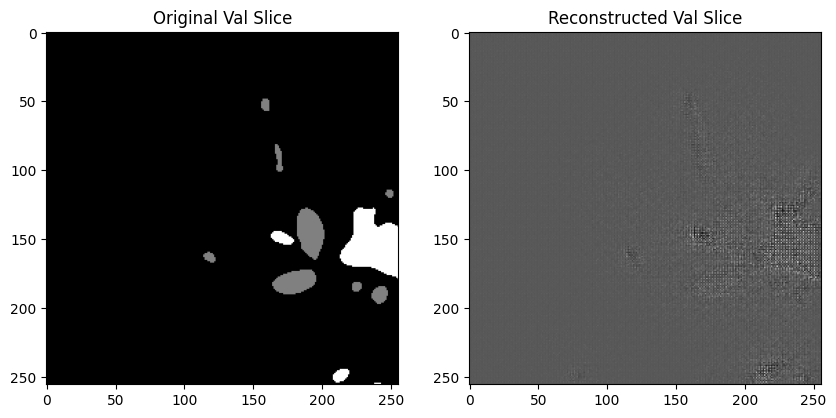

Epoch 0:   0%|          | 0/8 [00:00<?, ?it/s]                             

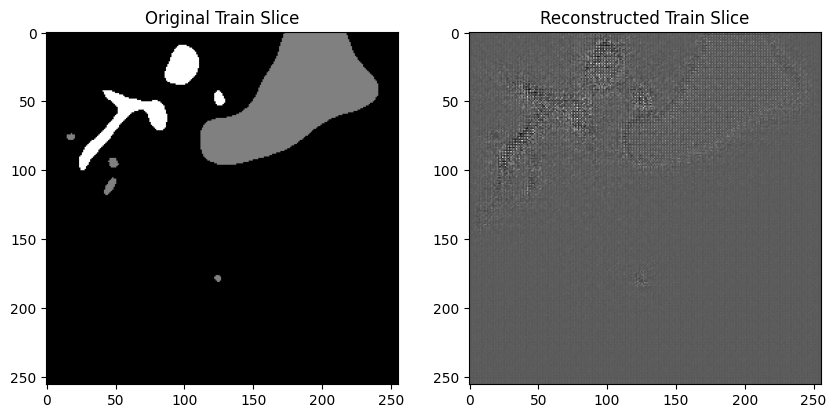

Epoch 0: 100%|██████████| 8/8 [00:24<00:00,  0.33it/s, v_num=1]

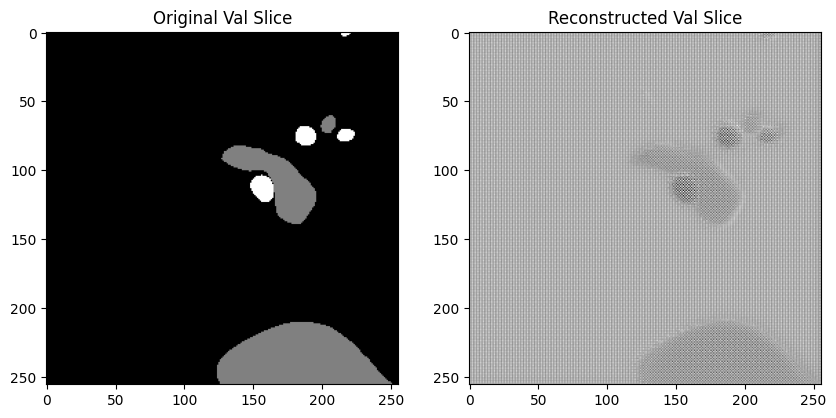

Epoch 2:   0%|          | 0/8 [00:00<?, ?it/s, v_num=1, val_loss=0.834]        

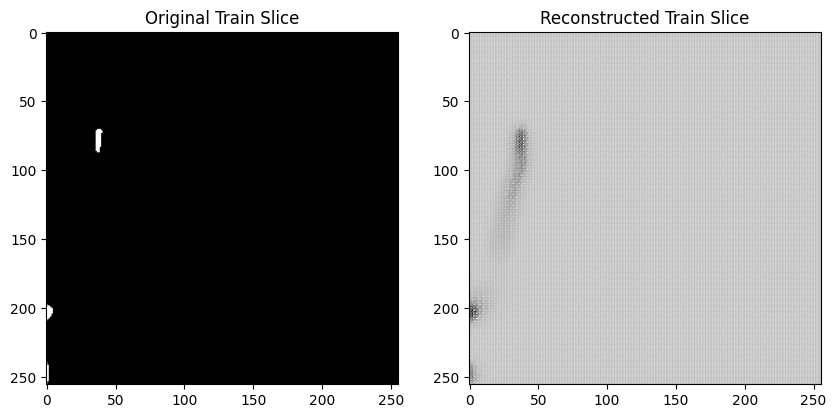

Epoch 2: 100%|██████████| 8/8 [00:24<00:00,  0.33it/s, v_num=1, val_loss=0.834]

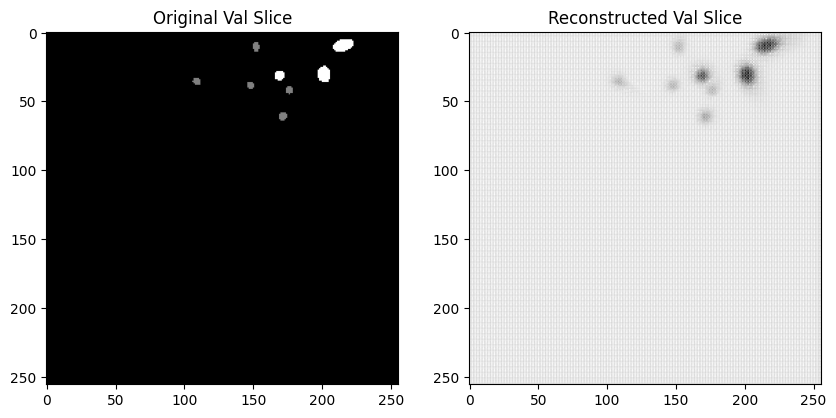

Epoch 4:   0%|          | 0/8 [00:00<?, ?it/s, v_num=1, val_loss=0.481]        

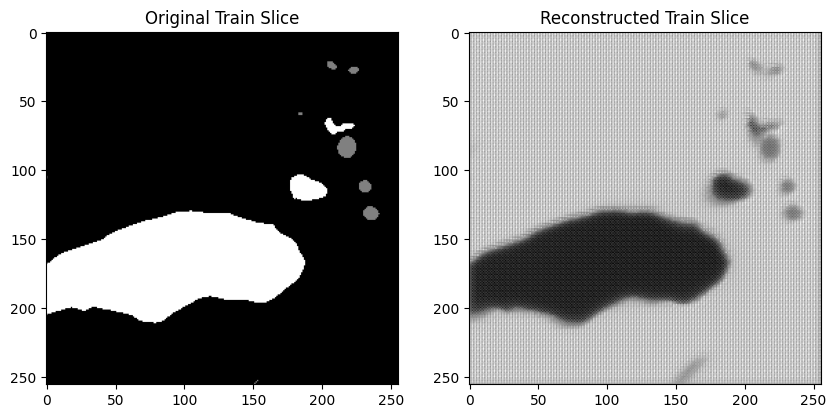

Epoch 4: 100%|██████████| 8/8 [00:23<00:00,  0.35it/s, v_num=1, val_loss=0.481]

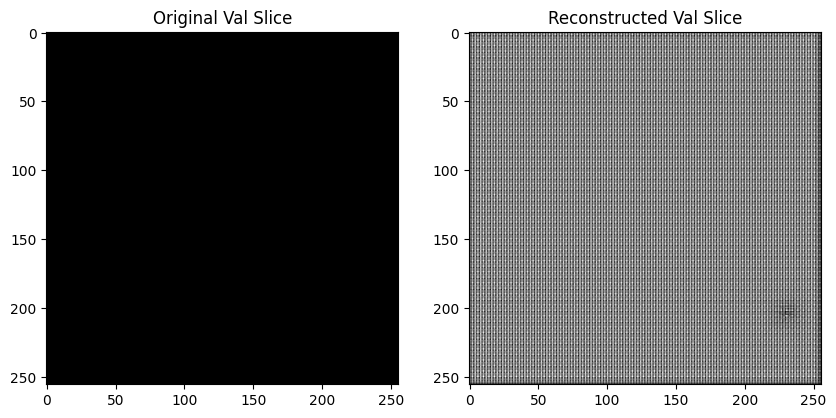

Epoch 6:   0%|          | 0/8 [00:00<?, ?it/s, v_num=1, val_loss=0.313]        

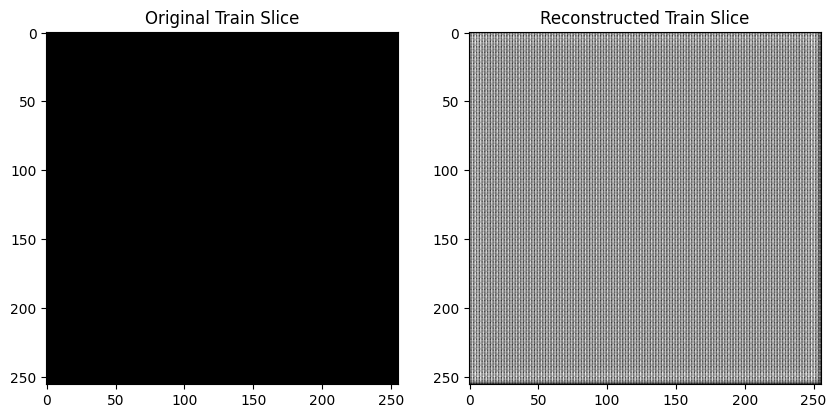

Epoch 6: 100%|██████████| 8/8 [00:25<00:00,  0.32it/s, v_num=1, val_loss=0.313]

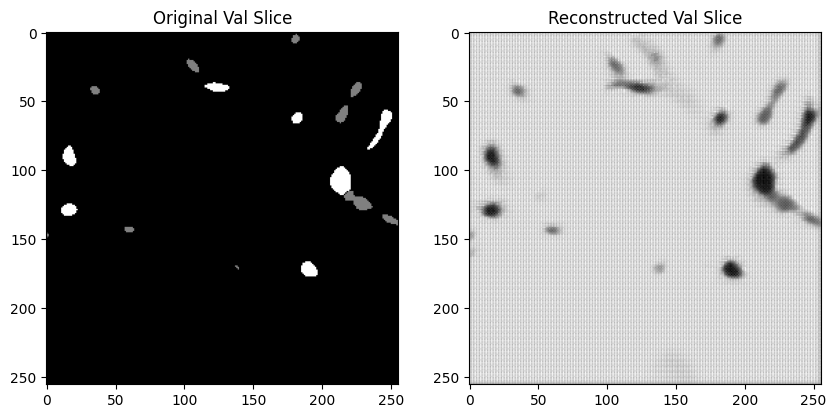

Epoch 8:   0%|          | 0/8 [00:00<?, ?it/s, v_num=1, val_loss=0.206]        

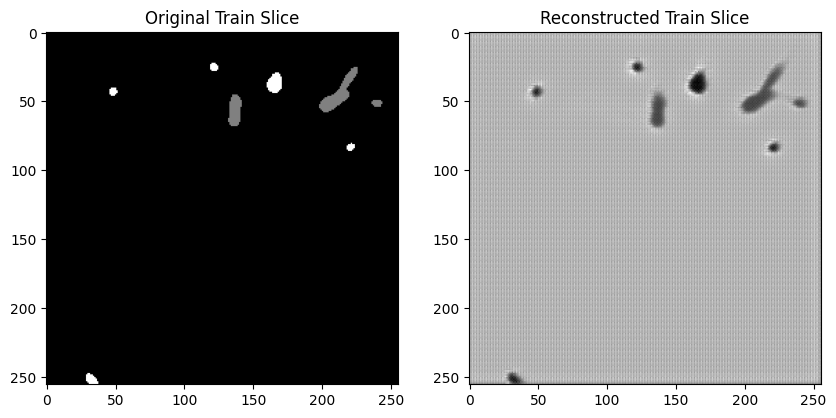

Epoch 8: 100%|██████████| 8/8 [00:22<00:00,  0.35it/s, v_num=1, val_loss=0.206]

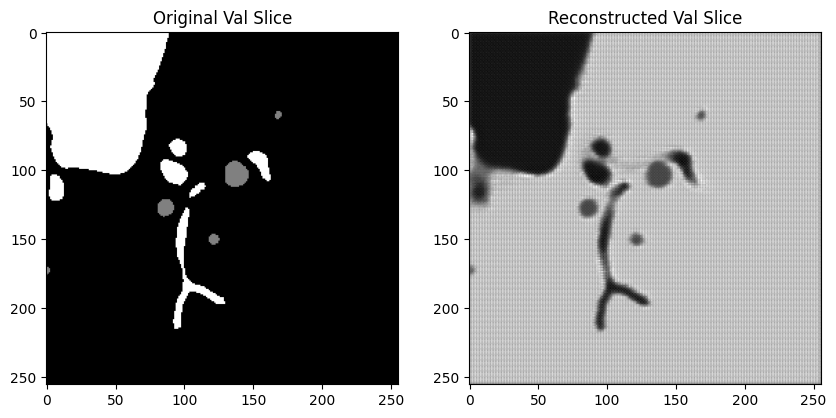

Epoch 9: 100%|██████████| 8/8 [00:58<00:00,  0.14it/s, v_num=1, val_loss=0.147]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 8/8 [00:58<00:00,  0.14it/s, v_num=1, val_loss=0.147]

FIT Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  6738           

In [52]:
import matplotlib.pyplot as plt 
class AutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.unet = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=3,  # Update to 3 output channels
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
        )
        # Define class weights
        class_weights = torch.tensor([0.2, 0.4, 0.4])
        self.loss_function = CrossEntropyLoss(weight=class_weights)

    def forward(self, x):
        return self.unet(x)


    def training_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self.unet(x)
        loss = self.loss_function(x_hat, y.squeeze(1).long())  # Ensure labels are in the range [0, 2]
        self.log('train_loss', loss)

        # Reconstruct and display a single slice from the first training image every other epoch
        if self.current_epoch % 2 == 0 and batch_idx == 0:
            original_slice = x[0, 0, :, :, 128].detach().cpu().numpy()  # Select a single slice from the 3D volume
            reconstruction_slice = self.unet(x[0].unsqueeze(0))[0, 0, :, :, 128].detach().cpu().numpy()  # Select a single slice from the 3D reconstruction

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(original_slice, cmap='gray')
            plt.title('Original Train Slice')
            plt.subplot(1, 2, 2)
            plt.imshow(reconstruction_slice, cmap='gray')
            plt.title('Reconstructed Train Slice')
            plt.show()

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self.unet(x)
        loss = self.loss_function(x_hat, y.squeeze(1).long())  # Ensure labels are in the range [0, 2]
        self.log('val_loss', loss, prog_bar=True)

        # Reconstruct and display a single slice from the first validation image every other epoch
        if self.current_epoch % 2 == 0 and batch_idx == 0:
            original_slice = x[0, 0, :, :, 128].detach().cpu().numpy()  # Select a single slice from the 3D volume
            reconstruction_slice = self.unet(x[0].unsqueeze(0))[0, 0, :, :, 128].detach().cpu().numpy()  # Select a single slice from the 3D reconstruction

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(original_slice, cmap='gray')
            plt.title('Original Val Slice')
            plt.subplot(1, 2, 2)
            plt.imshow(reconstruction_slice, cmap='gray')
            plt.title('Reconstructed Val Slice')
            plt.show()

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


# Define dataset and data loaders for both training and validation sets
train_data_dir = "./images/TrainFullLabels30"
val_data_dir = "./images/ValFullLabels70"

transform = Compose([
    Lambda(func=lambda x: np.expand_dims(x, 0) if x.ndim == 3 else x),
    RandSpatialCrop((256, 256, 256), random_size=False),
    RandRotate90(prob=0.5),
    ToTensor(dtype=torch.float32)
])

class MyDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.nrrd')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data, header = nrrd.read(file_path)
        if self.transform:
            data = self.transform(data)
        return data, data

train_dataset = MyDataset(train_data_dir, transform)
val_dataset = MyDataset(val_data_dir, transform)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0)

# Define a custom callback to plot both training and validation losses
class PlotLossCallback(pl.Callback):
    def __init__(self, log_dir):
        super().__init__()
        self.log_dir = log_dir

    def on_train_start(self, trainer, pl_module):
        # Clear previous graphs
        tf.compat.v1.reset_default_graph()
        self.writer = SummaryWriter(self.log_dir)

    def on_train_epoch_end(self, trainer, pl_module, **kwargs):
        epoch = trainer.current_epoch
        train_loss = trainer.callback_metrics['train_loss'].cpu().item()
        val_loss = trainer.callback_metrics['val_loss'].cpu().item()

        # Write both training and validation loss to the same graph
        self.writer.add_scalar('Loss/TrainVal', train_loss, global_step=epoch)
        self.writer.add_scalar('Loss/TrainVal', val_loss, global_step=epoch)

    def on_train_end(self, trainer, pl_module):
        self.writer.close()

# Define Lightning trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[PlotLossCallback("./logs/")],
    profiler='simple'
)

# Initialize model and start training
model = AutoEncoder()
trainer.fit(model, train_dataloader, val_dataloader)

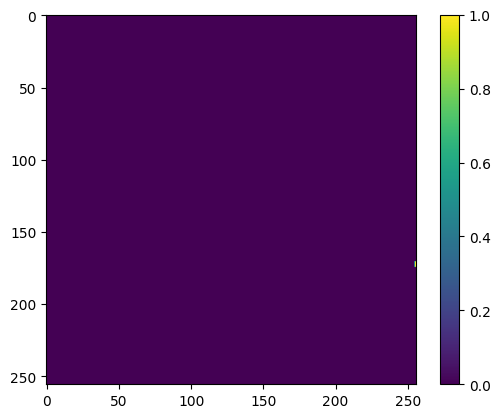

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Generate example 2D image data
# Display the image with a colorbar
plt.imshow(np.argmax(reconstructed_images[i][0, :, :, :, 256//2], axis=0), cmap='viridis')
plt.colorbar()
plt.show()

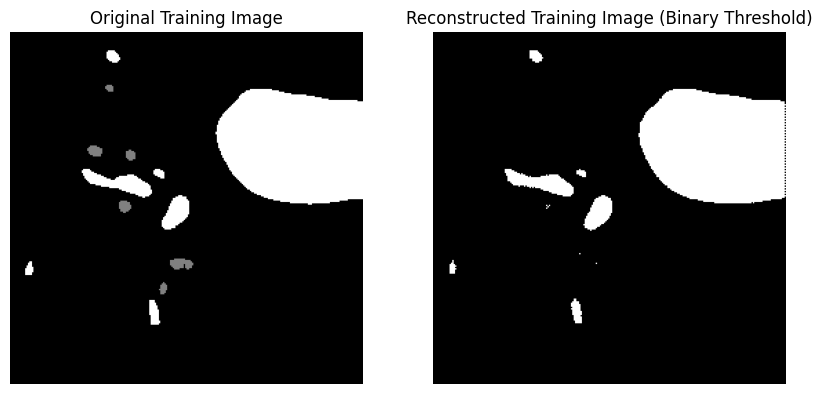

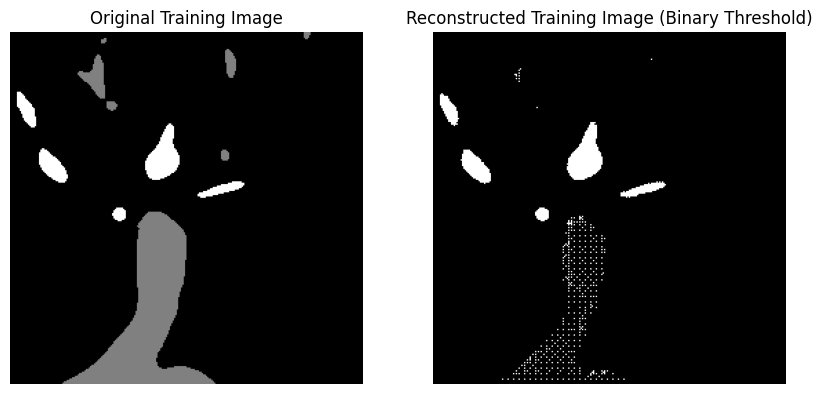

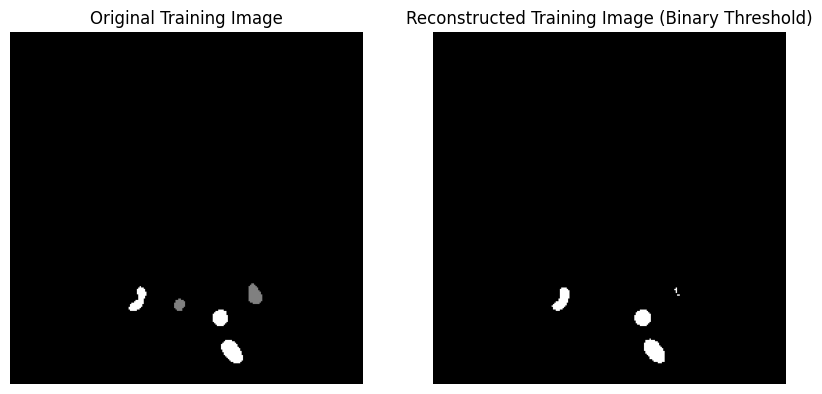

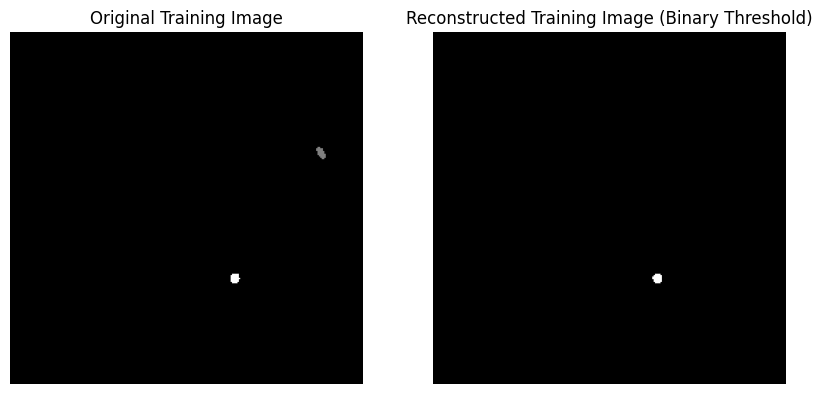

In [13]:
#PASSING NEW IMAGE THROUGH 
import matplotlib.pyplot as plt
import numpy as np

data_dir = data_dir = "./images/TempLabels"
dataset_ = MyDataset(data_dir, transform)
dataloader_ = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
# Set the model to evaluation mode
model.eval()

# Pass the original data through the model to get reconstructed images
reconstructed_images = []
original_images = []
for data, _ in dataloader:
    with torch.no_grad():
        reconstructed = model(data)
    reconstructed_images.append(reconstructed.cpu().numpy())
    original_images.append(data.cpu().numpy())

# Visualize original and reconstructed images
num_samples = len(reconstructed_images)
for i in range(num_samples):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Original Image
    axes[0].imshow(original_images[i][0, 0, :, :, 256//2], cmap='gray')  
    axes[0].set_title('Original Training Image')
    axes[0].axis('off')
    
    # Reconstructed Image with Binary Threshold
    reconstructed_norm = reconstructed_images[i][0, 0, :, :, 256//2] / np.max(reconstructed_images[i][0, 0, :, :, 256//2])  # Normalize to [0, 1]
    reconstructed_binary = np.where(reconstructed_norm > 0.5, 1, 0)
    axes[1].imshow(reconstructed_binary, cmap='gray') 
    axes[1].set_title('Reconstructed Training Image (Binary Threshold)')
    axes[1].axis('off')
    
    plt.show()